In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from modules.rq_vae import RQ_VAE
import torch.optim as optim
from tqdm import tqdm
import cProfile
import pstats
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
embeddings = np.load('./data/ml-25m-clip_none/embed_image.npy')

emb_shape = np.array(embeddings).shape
vae_input_dim = emb_shape[1]
vae_hidden_dims=[768, 512, 256]
vae_embed_dim=128

vae_codebook_size=256
dropout=0.1
vae_codebook_normalize=True
vae_sim_vq=False
vae_n_layers=3

use_kmeans_init=False

learning_rate=0.001
weight_decay=0.1

batch_size=2048
commitment_weight=0.25
iterations=8000

embeddings = torch.tensor(embeddings, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(embeddings), batch_size=batch_size, shuffle=True)

In [4]:
model = RQ_VAE(
    input_dim=vae_input_dim,
    latent_dim=vae_embed_dim,
    hidden_dims=vae_hidden_dims,
    codebook_size=vae_codebook_size,
    codebook_kmeans=use_kmeans_init,
    codebook_normalization=vae_codebook_normalize,
    codebook_sim_vq=vae_sim_vq,
    num_layers=vae_n_layers,
    beta_commit=commitment_weight,
    num_cat_features=0,
)
from torch.amp import autocast, GradScaler

scaler = GradScaler(device='cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def train(num_epochs=250): 
    # Set up optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    epoch_progress = tqdm(range(num_epochs), desc="Training Progress")
    for epoch in epoch_progress:
        model.train()
        
        total_loss = 0
        total_reconstruction_loss = 0
        total_rqvae_loss = 0
        
        for _, (embeddings_batch,) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()
            embeddings_batch = embeddings_batch.to(device)
            # Forward pass
            # loss, reconstruction_loss, rqvae_loss, embs_norm, p_unique_ids
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                losses = model(embeddings_batch)

            scaler.scale(losses[0]).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += losses[0].item()
            total_reconstruction_loss += losses[1].item()
            total_rqvae_loss += losses[2].item()
            
        epoch_progress.set_postfix({
            "Loss": f"{total_loss / len(train_loader):.4f}",
            "Reconstruction": f"{total_reconstruction_loss / len(train_loader):.4f}",
            "RQ-VAE": f"{total_rqvae_loss / len(train_loader):.4f}"
        })
        
train = False
if train:
    # Train the model
    train(iterations)
    torch.save(model.state_dict(), './models/rq-vae.pt')
else:
    # Load the model
    model.load_state_dict(torch.load('./models/rq-vae.pt'))

In [13]:

sem_ids = []
interactions = pd.read_csv('./data/ml-25m-clip_none/test.txt')
interactions = interactions.dropna()
num_users = interactions['user'].unique().shape[0]


for i in tqdm(range(59047)):
    song = embeddings[i].clone().detach().unsqueeze(0)
    song = song.to(device)
    with torch.no_grad():
        # embeddings, residuals, sem_ids, quantize_loss
        rqvae_output = model.get_semantic_ids(song, False)
        sem_ids.append(rqvae_output[2])
sem_ids_cpu = [tensor.cpu() for tensor in sem_ids]
sem_ids_cpu = np.array(sem_ids_cpu)[:,0,:]

100%|██████████| 59047/59047 [02:20<00:00, 420.31it/s]


In [16]:
def plot_sem_ids_3d(sem_ids_user):
    values = np.zeros((vae_n_layers, len(sem_ids_user)))
    
    for idx, tensor in enumerate(sem_ids_user):
        for i in range(vae_n_layers):
            values[i][idx] = tensor[i].item()
    
    plot_3d_scatter(values[0], values[1], values[2])

def plot_3d_scatter(x_values, y_values, z_values):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x_values, y_values, z_values, c='blue', marker='o')
    
    ax.set_xlim(0, vae_codebook_size - 1)
    ax.set_ylim(0, vae_codebook_size - 1)
    ax.set_zlim(0, vae_codebook_size - 1)

    ax.set_xlabel('SID Axis 1')
    ax.set_ylabel('SID Axis 2')
    ax.set_zlabel('SID Axis 3')
    
    ax.set_title('3D Scatter Plot of SEM IDs')
    
    plt.show()
    
def find_sids_for_user(interactions, user_id, user_col_name, item_col_name):
    int_items = np.array(interactions.where(interactions[user_col_name] == user_id).dropna()[item_col_name].values, dtype=int)
    sids = []
    for items in int_items:
        sids.append(sem_ids_cpu[items])
        
    return np.array(sids)

In [18]:
sem_ids_cpu

array([[159, 245, 134],
       [159, 245, 134],
       [159, 245, 134],
       ...,
       [159, 245, 134],
       [159, 245, 134],
       [159, 245, 134]])

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


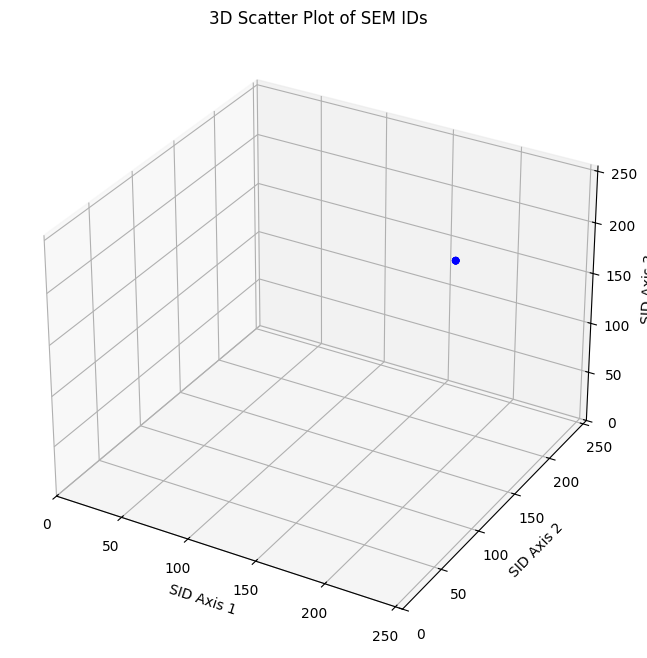

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


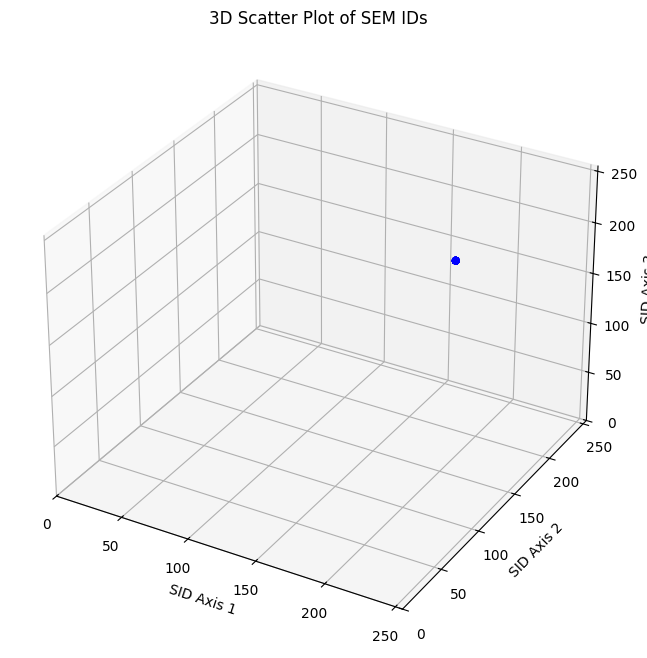

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


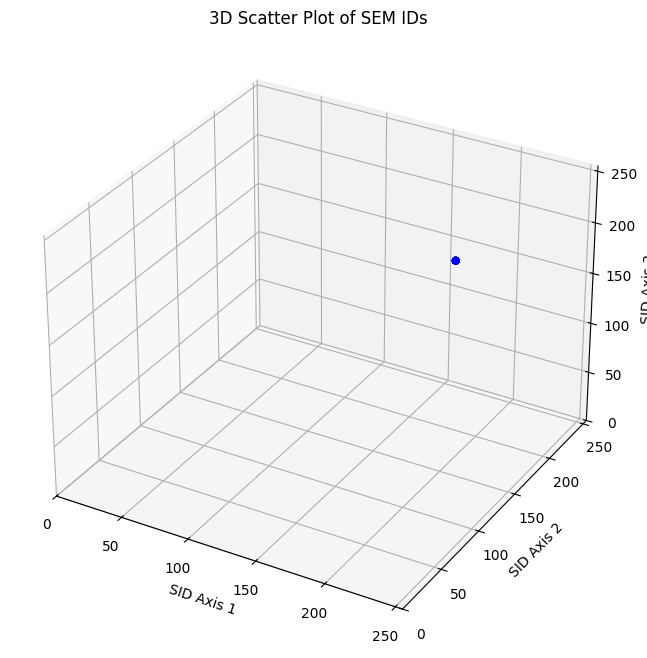

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


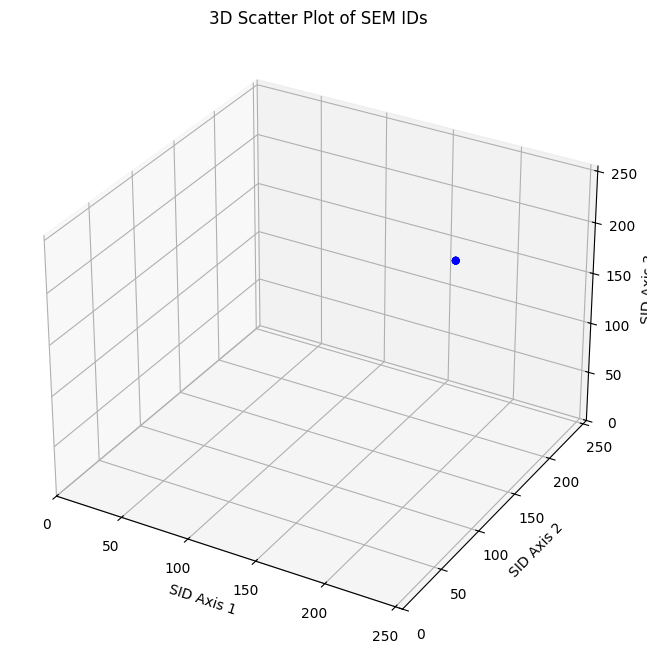

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

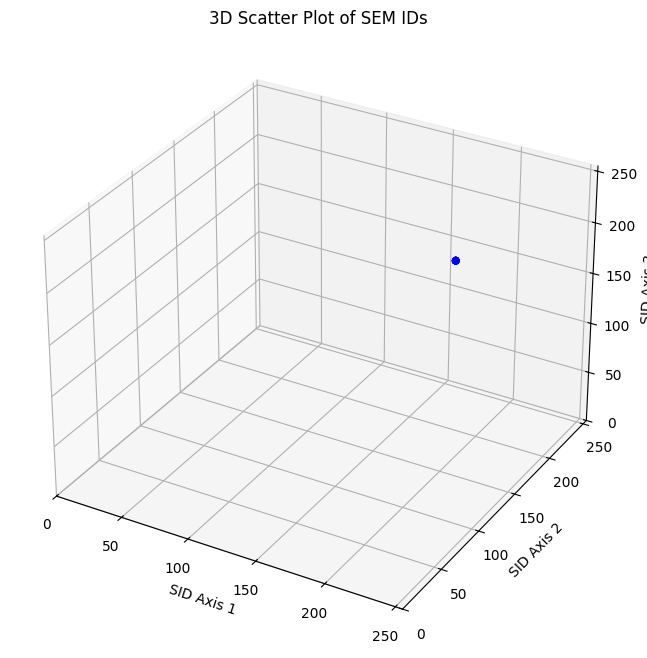

In [17]:
for i in range(5):
    user_id = np.random.randint(0, 59047)
    sids = find_sids_for_user(interactions, user_id, 'user', 'item')
    mat = cosine_similarity(sids, sids)
    print(mat)
    plot_sem_ids_3d(sids)